In [ ]:
!pip install timm
from torchvision.models import convnext_large, ConvNeXt_Large_Weights
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.profiler import profile, record_function, ProfilerActivity
from timm import create_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Архитектура

In [ ]:
model_name = "convnext_small_in22k"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ConvNeXt model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/convnext.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


In [ ]:
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine

### Посмотрим, сколько каждая часть ConvNeXt работает по времени и сколько занимает памяти

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
 
#create a dummy input
inputs = torch.randn(10, 3, 224, 224).to(device)
 
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         4.94%       7.046ms        24.52%      34.969ms      34.969ms       0.000us         0.00%     215.697ms     215.697ms             1  
                                           aten::conv2d         0.10%     147.000us         8.34%      11.894ms     297.350us       0.000us         0.00%     124.178ms       3.104ms            40  
         

In [ ]:
#Analyzing memory consumption
with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               aten::mm        10.97%       2.868ms        15.11%       3.949ms      54.847us           0 b           0 b     669.39 Mb     669.39 Mb            72  
                                             aten::gelu         2.38%     621.000us         3.24%     847.000us      23.528us           0 b           0 b     534.21 Mb     534.21 Mb            36  
         

### Пример работы ConvNeXt


In [ ]:
!wget https://dl.fbaipublicfiles.com/convnext/label_to_words.json
imagenet_labels = json.load(open('label_to_words.json'))

--2022-10-09 12:24:42--  https://dl.fbaipublicfiles.com/convnext/label_to_words.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773945 (756K) [application/json]
Saving to: ‘label_to_words.json’

label_to_words.json 100%[===================>] 755.81K   252KB/s    in 3.0s    

2022-10-09 12:24:46 (252 KB/s) - ‘label_to_words.json’ saved [773945/773945]



In [ ]:
!wget https://dl.fbaipublicfiles.com/convnext/test.jpeg
img_1 = PIL.Image.open('test.jpeg')
img_2 = PIL.Image.open('test_2.jpg')
img_3 = PIL.Image.open('test_3.jpg')
img_4 = PIL.Image.open('test_4.jpg')

--2022-10-09 12:30:31--  https://dl.fbaipublicfiles.com/convnext/test.jpeg
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165227 (161K) [image/jpeg]
Saving to: ‘test.jpeg.1’

test.jpeg.1         100%[===================>] 161.35K   281KB/s    in 0.6s    

2022-10-09 12:30:33 (281 KB/s) - ‘test.jpeg.1’ saved [165227/165227]



In [ ]:
from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

NORMALIZE_MEAN = IMAGENET_DEFAULT_MEAN
NORMALIZE_STD = IMAGENET_DEFAULT_STD
SIZE = 256

# Here we resize smaller edge to 256, no center cropping
transforms = T.Compose([
              T.Resize(SIZE, interpolation=T.InterpolationMode.BICUBIC),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ])

In [ ]:
def inference(img):
    img_tensor = transforms(img).unsqueeze(0).to(device)
    output = torch.softmax(model(img_tensor), dim=1)
    top5 = torch.topk(output, k=5)
    top5_prob = top5.values[0]
    top5_indices = top5.indices[0]

    for i in range(5):
        labels = imagenet_labels[str(int(top5_indices[i]))]
        prob = "{:.2f}%".format(float(top5_prob[i])*100)
        print(labels, prob)

    plt.imshow(img)

egg, eggs 18.83%
incubator, brooder 10.21%
egg white, white, albumen, ovalbumin 3.05%
electric refrigerator, fridge 2.87%
ping-pong ball 2.20%


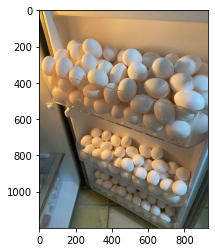

In [ ]:
inference(img_1)

European tortoise, Testudo graeca 17.52%
testudo 10.85%
chelonian, chelonian reptile 5.66%
desert tortoise, Gopherus agassizii 2.48%
Texas tortoise 2.40%


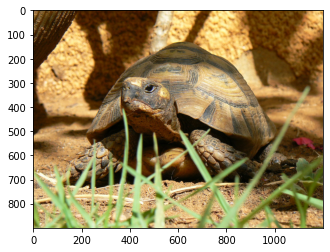

In [ ]:
inference(img_2)

fighter pilot 15.29%
pompadour 9.70%
aviator, aeronaut, airman, flier, flyer 2.11%
aviatrix, airwoman, aviatress 1.79%
toupee, toupe 1.51%


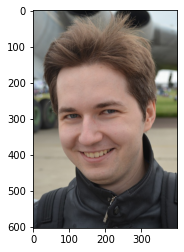

In [ ]:
inference(img_3)

counselor, counsellor 2.55%
licentiate 1.04%
Anglo-American 1.03%
generator, source, author 1.02%
business editor 1.01%


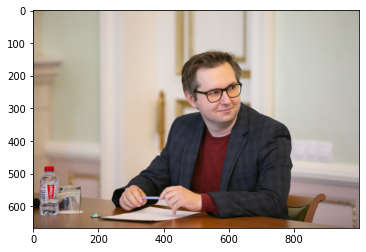

In [ ]:
inference(img_4)